# Link to World Bank Dataset Overview
https://financesone.worldbank.org/api-explorer?id=DS00975

# 📘 Loan Cancellation and Disbursement Behavior Prediction

## Problem Statement
The goal of this project is to predict loan cancellation and disbursement outcomes as indicators of a country’s ability to repay its loans.

## Topic
**Loan Cancellation and Disbursement Behavior Prediction**

---

## Phase 1: Data Acquisition
- [x] Create public repositroy through GitHub  
- [x] Connect Open Source World Bank dataset to Jupyter Notebook via World Bank API
- [x] Implement partial downloading of data to save progress and prevent system throttling 
- [x] Progress bar to track download of data
- [x] Store Data in .parquet file for compression and easy read

---

## Phase 2: Data Preparation

- [ ] Clean dataset and remove irrelevant columns  
- [ ] Impute missing values using a pretrained model
- [x] One Hot Encode Categorical Variables
- [x] Use scalar on loan amount 
- [ ] Mask sensitive data using models
- [x] Feature Engineering    
- [x] Combine Multiple datasets from various sources

---

## Phase 3: Model Implementation
- [ ] Implement machine learning models to predict loan disbursement and cancellation behavior 
- [ ] Implement hugging face tabular transformer based model
- [ ] Evaluate performance using appropriate metrics (accuracy, F1-score, ROC-AUC)  
- [ ] Compare baseline models vs. advanced models (e.g., Hugging Face TabTransformer) 
- [ ] Fine tune variables preventing Feature leakage and model cheating
- [ ] HyperParameter Tuning for optimal accuracy

---

## Phase 4: Model Deployment
- [ ] Deploy the trained model using **Hugging Face Spaces** or **Azure Machine Learning**  
- [ ] Create a simple web-based interface for predictions and visual insights  

---

## Phase 5: Dataset Expansion
- [ ] Merge an additional dataset (e.g., GDP data)  
- [ ] Join using the **World Bank Country Code**  
- [ ] Analyze the impact of macroeconomic indicators on loan outcomes  

---

## Phase 6 Challenges and Things to Consider:

- [ ] Countries Changing Yugoslavia → Serbia , Zaire → DR Congo
- [ ] Payment distribution more than loan because of inflation  
- [ ] Extremely Messy inconsistent data to be used with caution and careful finetuning


## 📈 Additional Topics to Explore
- **Loan Default Risk Prediction**  
- **Loan Repayment Time Forecasting**  
- **Regional Loan Portfolio Performance Analysis**
- **CI/CD With Versioning**
- **Containerzation**
- **Local Flask API Endpoint For Interaction**
- **Bronze/Silver/Gold Best Practice Data Storage SQLlite**
---

## Objective Summary
This project aims to build an interpretable AI model capable of predicting loan cancellation and disbursement behavior using historical World Bank data, regional attributes, and macroeconomic indicators. The findings will help assess each country’s ability to fulfill its loan obligations and guide data-driven lending decisions.


In [ ]:
import requests, json, time, os
from tqdm import tqdm

def fetch_all_data():
    base_url = "https://datacatalogapi.worldbank.org/dexapps/fone/api/apiservice"
    dataset_id = "DS00975"
    resource_id = "RS00905"
    top = 1000
    page = 1
    all_data = []

    # 🔁 Resume if a partial file already exists
    if os.path.exists("worldbank_partial.json"):
        with open("worldbank_partial.json") as f:
            all_data = json.load(f)
        page = len(all_data)//top + 1
        print(f"Resuming from page {page} ({len(all_data):,} records already saved)")

    with tqdm(total=1472089, desc="Downloading rows", unit="rows") as pbar:
        pbar.update(len(all_data))
        while True:
            url = f"{base_url}?datasetId={dataset_id}&resourceId={resource_id}&top={top}&type=json&skip={1000*(page-1)}"
            try:
                r = requests.get(url, timeout=20)
                r.raise_for_status()
                data = r.json()
                if "data" not in data or not data["data"]:
                    break
                all_data.extend(data["data"])
                pbar.update(len(data["data"]))

                if page % 10 == 0:
                    with open("worldbank_partial.json", "w") as f:
                        json.dump(all_data, f)
                    print(f"Saved checkpoint at page {page} ({len(all_data):,} rows)")
                page += 1
                time.sleep(0.2)
            except requests.RequestException as e:
                print(f"Error on page {page}: {e}. Retrying in 10s.")
                time.sleep(10)
                continue

    # Final save
    with open("worldbank_loans_full.json", "w") as f:
        json.dump(all_data, f)
    print(f"\n✅ Download complete — {len(all_data):,} records saved.")
    return all_data

if __name__ == "__main__":
    all_data = fetch_all_data()


In [ ]:
import pandas as pd
df = pd.read_json("worldbank_loans_full.json")
df.to_parquet("worldbank_loans.parquet")


In [1]:
import pandas as pd
df = pd.read_parquet("worldbank_loans.parquet")

gdp_total = pd.read_csv("gdp_total.csv")
gdp_per_capita = pd.read_csv("gdp_per_capita.csv")

gdp = gdp_total.merge(
    gdp_per_capita,
    on=["Country", "Year"],
    how="outer",  # use "outer" so you keep rows that appear in only one file
    suffixes=("_total", "_per_capita")
)

gdp.to_csv("gdp_combined.csv", index=False)


In [2]:

import pycountry

# keep only valid ISO3 countries (filter out regions)
valid_iso3 = {c.alpha_3 for c in pycountry.countries}
gdp = gdp[gdp["Country"].isin(valid_iso3) | gdp["Country"].eq("XKX")]

# then map to ISO2 and merge
iso3_to_iso2 = {c.alpha_3: c.alpha_2 for c in pycountry.countries}
gdp["country_code"] = gdp["Country"].map(iso3_to_iso2)
# --- 3. Manual fixes for edge cases ---
manual_fixes = {
    "XKX": "XK",   # Kosovo (World Bank pseudo-ISO)
    "SRB": "YU",   # Yugoslavia → Serbia (officially split; use RS)
    "SCG": "RS",   # Serbia and Montenegro → Serbia
    "TLS": "TL",   # Timor-Leste (old code TMP / TP → TL)
    "COD": "ZR",   # Zaire → DR Congo
    "TWN": "TW",   # Taiwan (ISO-3 = TWN → ISO-2 = TW)
}

# Apply manual fixes safely
gdp["country_code"] = gdp.apply(
    lambda row: manual_fixes.get(row["Country"], row["country_code"]),
    axis=1
)


In [3]:
gdp["Country"].unique()

array(['ABW', 'AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ASM',
       'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD',
       'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BMU', 'BOL', 'BRA',
       'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN',
       'CIV', 'CMR', 'COD', 'COG', 'COL', 'COM', 'CPV', 'CRI', 'CUB',
       'CUW', 'CYM', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA', 'DNK', 'DOM',
       'DZA', 'ECU', 'EGY', 'ERI', 'ESP', 'EST', 'ETH', 'FIN', 'FJI',
       'FRA', 'FRO', 'FSM', 'GAB', 'GBR', 'GEO', 'GHA', 'GIB', 'GIN',
       'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 'GRL', 'GTM', 'GUM', 'GUY',
       'HKG', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IMN', 'IND', 'IRL',
       'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN', 'KAZ',
       'KEN', 'KGZ', 'KHM', 'KIR', 'KNA', 'KOR', 'KWT', 'LAO', 'LBN',
       'LBR', 'LBY', 'LCA', 'LIE', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA',
       'MAC', 'MAF', 'MAR', 'MCO', 'MDA', 'MDG', 'MDV', 'MEX', 'MHL',
       'MKD', 'MLI',

In [4]:
# 1️⃣ Replace YF → YU
df["country_code"] = df["country_code"].replace("YF", "YU")

df["country_code"] = df["country_code"].replace("TP", "TL")

# 2️⃣ Define invalid / regional codes to delete
invalid_codes = {None, "3W", "3E", "3S", "6R", "TW"}

# 3️⃣ Drop rows containing them
df = df[~df["country_code"].isin(invalid_codes)].copy()

# 4️⃣ Optional: confirm
print("Unique after cleanup:", df["country_code"].nunique())
print("Remaining bad values:", set(df["country_code"].unique()) & invalid_codes)



Unique after cleanup: 141
Remaining bad values: set()


In [5]:
# Get unique country codes from both DataFrames
df_codes = set(df["country_code"].dropna().unique())
gdp_codes = set(gdp["country_code"].dropna().unique())

# 1️⃣ Codes in df but not in gdp
missing_from_gdp = df_codes - gdp_codes

# 2️⃣ Codes in gdp but not in df
missing_from_df = gdp_codes - df_codes

print("🚫 In df but missing from gdp:", missing_from_gdp)

🚫 In df but missing from gdp: set()


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1464881 entries, 0 to 1472088
Data columns (total 33 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   agreement_signing_date      1443135 non-null  object 
 1   board_approval_date         1464879 non-null  object 
 2   borrower                    1454847 non-null  object 
 3   borrowers_obligation        1464881 non-null  float64
 4   cancelled_amount            1464881 non-null  float64
 5   closed_date_most_recent     1463503 non-null  object 
 6   country                     1464881 non-null  object 
 7   country_code                1464881 non-null  object 
 8   currency_of_commitment      65007 non-null    object 
 9   disbursed_amount            1464881 non-null  float64
 10  due_3rd_party               1464881 non-null  int64  
 11  due_to_ibrd                 1464881 non-null  float64
 12  effective_date_most_recent  1452965 non-null  object 
 13  en

In [8]:
# Extract year from board_approval_date
df["Year"] = pd.to_datetime(df["board_approval_date"], errors="coerce").dt.year


In [9]:
df = pd.merge(
    df,
    gdp,
    how="left",
    on=["country_code", "Year"]
)




In [10]:
df.describe()

,borrowers_obligation,cancelled_amount,disbursed_amount,due_3rd_party,due_to_ibrd,exchange_adjustment,interest_rate,loans_held,original_principal_amount,repaid_3rd_party,repaid_to_ibrd,sold_3rd_party,undisbursed_amount,Year,gdp_total,gdp_per_capita
count,1.464881e+06,1.464881e+06,1.464881e+06,1464881.0,1.464881e+06,1.464881e+06,1.432557e+06,1.464881e+06,1.464881e+06,1.464881e+06,1.464881e+06,1.464881e+06,1.464881e+06,213140.000000,2.030540e+05,203054.000000
mean,2.301814e+07,1.054454e+07,6.711993e+07,0.0,2.343781e+07,-4.196706e+05,4.359288e+00,3.178311e+07,8.606784e+07,4.324957e+05,4.335121e+07,4.324957e+05,8.345298e+06,1988.481233,4.093916e+11,2270.652941
std,9.852076e+07,4.735001e+07,1.388271e+08,0.0,1.021241e+08,1.181330e+07,3.387013e+00,1.189377e+08,1.577561e+08,3.826197e+06,9.314572e+07,3.826197e+06,5.206127e+07,13.965075,1.489406e+12,2587.158594
min,-3.300000e-01,0.000000e+00,0.000000e+00,0.0,-1.483090e+08,-1.100785e+09,0.000000e+00,-1.483090e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.226600e+08,1947.000000,5.412944e+07,77.790185
25%,0.000000e+00,0.000000e+00,6.795234e+06,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.230500e+07,0.000000e+00,2.872563e+06,0.000000e+00,0.000000e+00,1979.000000,1.010185e+10,519.774063
50%,0.000000e+00,2.622700e+02,2.393006e+07,0.0,0.000000e+00,0.000000e+00,5.210000e+00,0.000000e+00,3.416949e+07,0.000000e+00,1.529584e+07,0.000000e+00,0.000000e+00,1987.000000,4.653890e+10,1367.187218
75%,0.000000e+00,3.859560e+06,7.000000e+07,0.0,0.000000e+00,0.000000e+00,7.250000e+00,0.000000e+00,1.000000e+08,0.000000e+00,4.564918e+07,0.000000e+00,0.000000e+00,1996.000000,1.816112e+11,2818.581456
max,2.842924e+09,1.995000e+09,3.153531e+09,0.0,2.923282e+09,5.065767e+08,2.825000e+01,3.750000e+09,3.750000e+09,2.499620e+08,3.000000e+09,2.499620e+08,3.379011e+09,2025.000000,1.874380e+13,30367.860576


In [11]:
df.drop_duplicates(subset=["loan_number"]).groupby("country")["original_principal_amount"].mean().sort_values(ascending=False).head(20)


country
South Africa               4.157650e+08
Kosovo                     3.856451e+08
Iraq                       3.228695e+08
Ukraine                    2.569107e+08
Angola                     2.562727e+08
Turkiye                    2.533687e+08
France                     2.500000e+08
Vietnam                    2.218158e+08
Poland                     2.056325e+08
India                      1.978916e+08
Kazakhstan                 1.967631e+08
Egypt, Arab Republic of    1.963796e+08
Russian Federation         1.701306e+08
Mexico                     1.578093e+08
Argentina                  1.575705e+08
Romania                    1.475898e+08
Viet Nam                   1.445926e+08
Brazil                     1.372873e+08
Czech Republic             1.252000e+08
Azerbaijan                 1.226710e+08
Name: original_principal_amount, dtype: float64

In [12]:
df["loan_number"].describe()

count       1464881
unique         9623
top       IBRD20000
freq            182
Name: loan_number, dtype: object

In [13]:
df_clean = df[[
    "loan_number", "country", "gdp_total", "gdp_per_capita", "country_code", "region",
    "original_principal_amount", "disbursed_amount", "cancelled_amount",
    "interest_rate", "loan_status", "loan_type",
    "board_approval_date", "end_of_period",
    "borrowers_obligation", "due_to_ibrd", "undisbursed_amount",
    "project_name_"
]].copy()


In [15]:
df_clean.head(5)

,loan_number,country,gdp_total,gdp_per_capita,country_code,region,original_principal_amount,disbursed_amount,cancelled_amount,interest_rate,loan_status,loan_type,board_approval_date,end_of_period,borrowers_obligation,due_to_ibrd,undisbursed_amount,project_name_
0,IBRD00010,France,NaN,NaN,FR,EUROPE AND CENTRAL ASIA,250000000.0,250000000.0,0.0,4.25,Fully Repaid,NPL,09-May-1947,30-Apr-2024,0.0,0.0,0.0,RECONSTRUCTION
1,IBRD00010,France,NaN,NaN,FR,EUROPE AND CENTRAL ASIA,250000000.0,250000000.0,0.0,4.25,Repaid,NON POOL,09-May-1947,30-Jun-2015,0.0,0.0,0.0,RECONSTRUCTION
2,IBRD00010,France,NaN,NaN,FR,EUROPE AND CENTRAL ASIA,250000000.0,250000000.0,0.0,4.25,Repaid,NON POOL,09-May-1947,31-May-2015,0.0,0.0,0.0,RECONSTRUCTION
3,IBRD00010,France,NaN,NaN,FR,EUROPE AND CENTRAL ASIA,250000000.0,250000000.0,0.0,4.00,Repaid,NON POOL,09-May-1947,30-Apr-2015,0.0,0.0,0.0,RECONSTRUCTION
4,IBRD00010,France,NaN,NaN,FR,EUROPE AND CENTRAL ASIA,250000000.0,250000000.0,0.0,4.25,Repaid,NON POOL,09-May-1947,31-Mar-2015,0.0,0.0,0.0,RECONSTRUCTION


In [16]:
# ✅ Store original row count
original_count = len(df_clean)

# ✅ Drop all rows where original_principal_amount == 0
df_clean = df_clean[df_clean["original_principal_amount"] != 0]

# ✅ Compute new count and how many were removed
new_count = len(df_clean)
removed = original_count - new_count

print(f"Total rows before: {original_count:,}")
print(f"Total rows after:  {new_count:,}")
print(f"Rows removed:      {removed:,} ({removed/original_count*100:.4f}% of total)")




Total rows before: 1,464,881
Total rows after:  1,418,434
Rows removed:      46,447 (3.1707% of total)


In [17]:
import numpy as np

df_clean["disbursement_ratio"] = np.where(
    df_clean["original_principal_amount"] > 0,
    df_clean["disbursed_amount"] / df_clean["original_principal_amount"],
    np.nan
)

df_clean["cancellation_ratio"] = np.where(
    df_clean["original_principal_amount"] > 0,
    df_clean["cancelled_amount"] / df_clean["original_principal_amount"],
    np.nan
)

df_clean[["original_principal_amount", "cancelled_amount", "cancellation_ratio", "disbursed_amount", "disbursement_ratio"]].describe()

,original_principal_amount,cancelled_amount,cancellation_ratio,disbursed_amount,disbursement_ratio
count,1.418434e+06,1.418434e+06,1.418434e+06,1.418434e+06,1.418434e+06
mean,8.888615e+07,1.065568e+07,1.416729e-01,6.913117e+07,8.028816e-01
std,1.595350e+08,4.701847e+07,2.675315e-01,1.405336e+08,3.173153e-01
min,9.224780e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.446000e+07,0.000000e+00,0.000000e+00,7.824870e+06,7.237313e-01
50%,3.630000e+07,6.038580e+03,2.848328e-04,2.500000e+07,9.862979e-01
75%,1.000000e+08,4.103749e+06,1.403513e-01,7.241180e+07,1.000000e+00
max,3.750000e+09,1.995000e+09,2.000000e+00,3.153531e+09,2.009506e+00


In [18]:
total = len(df_clean)

disb_over_1 = (df_clean["disbursement_ratio"] > 1).sum()
canc_over_1 = (df_clean["cancellation_ratio"] > 1).sum()

print(f"Loans with disbursement_ratio > 1: {disb_over_1:,} ({disb_over_1 / total * 100:.4f}%)")
print(f"Loans with cancellation_ratio > 1:  {canc_over_1:,} ({canc_over_1 / total * 100:.4f}%)")



Loans with disbursement_ratio > 1: 28,030 (1.9761%)
Loans with cancellation_ratio > 1:  28 (0.0020%)


In [19]:
# Store anomalies separately
over_disbursed = df_clean[df_clean["disbursement_ratio"] > 1].copy()

# Then clip for modeling
df_clean["disbursement_ratio"] = df_clean["disbursement_ratio"].clip(0, 1)
df_clean["cancellation_ratio"] = df_clean["cancellation_ratio"].clip(0, 1)

print(f"Saved {len(over_disbursed):,} over-disbursed loans for analysis.")


Saved 28,030 over-disbursed loans for analysis.


In [20]:
def categorize(row):
    if row["cancellation_ratio"] == 0:
        return "Fully Disbursed"
    elif row["cancellation_ratio"] < 0.2:
        return "Minor Cancellation"
    else:
        return "Major Cancellation"

df_clean["loan_outcome"] = df_clean.apply(categorize, axis=1)
df_clean["loan_outcome"].value_counts(normalize=True).round(3)



loan_outcome
Fully Disbursed       0.483
Minor Cancellation    0.300
Major Cancellation    0.218
Name: proportion, dtype: float64

In [21]:
feature_cols = [
    "country", "gdp_total", "gdp_per_capita", "region", "loan_type", "loan_status",
    "interest_rate", "original_principal_amount",
    "borrowers_obligation", "due_to_ibrd", "undisbursed_amount"
]
df_clean[feature_cols].describe()

,gdp_total,gdp_per_capita,interest_rate,original_principal_amount,borrowers_obligation,due_to_ibrd,undisbursed_amount
count,1.964590e+05,196459.000000,1.387576e+06,1.418434e+06,1.418434e+06,1.418434e+06,1.418434e+06
mean,4.183804e+11,2264.859116,4.285871e+00,8.888615e+07,2.368563e+07,2.411950e+07,8.538492e+06
std,1.513096e+12,2600.799076,3.390619e+00,1.595350e+08,1.000070e+08,1.036699e+08,5.267321e+07
min,5.412944e+07,77.790185,0.000000e+00,9.224780e+03,-3.300000e-01,-1.483090e+08,-1.226600e+08
25%,1.005885e+10,511.400884,0.000000e+00,1.446000e+07,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.626643e+10,1361.192519,5.110000e+00,3.630000e+07,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.768921e+11,2812.237546,7.250000e+00,1.000000e+08,0.000000e+00,0.000000e+00,0.000000e+00
max,1.874380e+13,30367.860576,2.825000e+01,3.750000e+09,2.842924e+09,2.923282e+09,3.379011e+09


In [22]:
(df_clean[["borrowers_obligation","due_to_ibrd","undisbursed_amount"]] == 0).mean() * 100


borrowers_obligation    73.559573
due_to_ibrd             76.527917
undisbursed_amount      91.719389
dtype: float64

In [23]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1️⃣ Clip impossible negatives
cols_to_clip = ["borrowers_obligation", "due_to_ibrd", "undisbursed_amount"]
for col in cols_to_clip:
    df_clean[col] = df_clean[col].clip(lower=0)

# 2️⃣ Log-transform (log1p handles 0 safely)
log_cols = ["original_principal_amount", "borrowers_obligation",
            "due_to_ibrd", "undisbursed_amount", "gdp_total", "gdp_per_capita"]
for col in log_cols:
    df_clean[f"log_{col}"] = np.log1p(df_clean[col])

# 3️⃣ Prepare list of numeric columns to scale
num_cols = ["interest_rate"] + [f"log_{col}" for col in log_cols]

# 4️⃣ Standardize (mean 0, std 1)  → use MinMaxScaler() if you prefer 0-1
scaler = StandardScaler()
df_clean[num_cols] = scaler.fit_transform(df_clean[num_cols])


In [24]:
# define your numeric (scaled) feature columns
num_cols = ["interest_rate",
             "log_original_principal_amount",
             "log_borrowers_obligation",
             "log_due_to_ibrd",
             "log_undisbursed_amount",
             "log_gdp_total", "log_gdp_per_capita"]

# combine with any categorical features if you want, but describe only numerics
df_clean[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
interest_rate,1387576.0,-3.983532e-16,1.000000,-1.264038,-1.264038,0.243062,0.874215,7.067776
log_original_principal_amount,1418434.0,5.759386e-15,1.000000,-5.615130,-0.603768,0.023190,0.713441,3.182183
log_borrowers_obligation,1418434.0,-1.237509e-16,1.000000,-0.534886,-0.534886,-0.534886,-0.534886,2.480333
log_due_to_ibrd,1418434.0,-2.261820e-16,1.000000,-0.539394,-0.539394,-0.539394,-0.539394,2.467370
log_undisbursed_amount,1418434.0,2.693025e-17,1.000000,-0.294427,-0.294427,-0.294427,-0.294427,4.284790
log_gdp_total,196459.0,8.638965e-15,1.000003,-3.215665,-0.709862,0.021983,0.665179,2.901569
log_gdp_per_capita,196459.0,-4.499235e-16,1.000003,-2.626490,-0.878728,0.033971,0.710964,2.931777


1418434

In [28]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_clean["loan_outcome_encoded"] = le.fit_transform(df_clean["loan_outcome"])

feature_cols = [
    "interest_rate",
    "log_original_principal_amount",
    "log_borrowers_obligation",
    "log_due_to_ibrd",
    "log_undisbursed_amount",
    "log_gdp_total", "log_gdp_per_capita"
]

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X = df_clean[feature_cols]
y = df_clean["loan_outcome_encoded"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'  # handles imbalance
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))




                    precision    recall  f1-score   support

   Fully Disbursed       0.85      0.41      0.55    136900
Major Cancellation       0.45      0.60      0.52     61803
Minor Cancellation       0.42      0.67      0.51     84984

          accuracy                           0.53    283687
         macro avg       0.57      0.56      0.53    283687
      weighted avg       0.63      0.53      0.53    283687

[[55830 23126 57944]
 [ 3291 37142 21370]
 [ 6689 21522 56773]]


In [ ]:

# cat_cols = [
#     "loan_type",
#     "region",
#     "country_code",
# ]


# feature_cols = [
#     "interest_rate",
#     "log_original_principal_amount",
#     "log_borrowers_obligation",
#     "log_due_to_ibrd",
#     "log_undisbursed_amount",
#     "log_gdp_total",
#     "log_gdp_per_capita"
# ]

# # Combine numeric + categorical
# all_features = feature_cols + cat_cols

# # Drop any rows missing target
# df_anova = df_clean.dropna(subset=["loan_outcome_encoded"])

# # Select features
# X = df_anova[all_features]
# y = df_anova["loan_outcome_encoded"]

# # One-hot encode categoricals (drop_first=True avoids dummy trap)
# X = pd.get_dummies(X, columns=cat_cols, drop_first=True)



In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# ==============================================
# 1️⃣ Encode your target
# ==============================================
le = LabelEncoder()
df_clean["loan_outcome_encoded"] = le.fit_transform(df_clean["loan_outcome"])

# ==============================================
# 2️⃣ Define numeric and categorical features
# ==============================================
cat_cols = ["loan_type", "region", "country_code"]

feature_cols = [
    "interest_rate",
    "log_original_principal_amount",
    "log_borrowers_obligation",
    "log_due_to_ibrd",
    "log_undisbursed_amount",
    "log_gdp_total",
    "log_gdp_per_capita"
]

# ==============================================
# 3️⃣ Drop rows with missing target or features
# ==============================================
df_model = df_clean.dropna(subset=["loan_outcome_encoded"] + feature_cols + cat_cols).copy()

# ==============================================
# 4️⃣ Build the model-ready X and y
# ==============================================
X = df_model[feature_cols + cat_cols]
y = df_model["loan_outcome_encoded"]

# One-hot encode categorical variables
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# ==============================================
# 5️⃣ Train/test split
# ==============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================================
# 6️⃣ Train Random Forest model
# ==============================================
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)

# ==============================================
# 7️⃣ Evaluate model
# ==============================================
y_pred = rf.predict(X_test)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))



Classification Report:

                    precision    recall  f1-score   support

   Fully Disbursed       0.89      0.75      0.82     17846
Major Cancellation       0.62      0.85      0.72      8798
Minor Cancellation       0.75      0.72      0.73     11865

          accuracy                           0.77     38509
         macro avg       0.75      0.77      0.76     38509
      weighted avg       0.79      0.77      0.77     38509


Confusion Matrix:

[[13468  2316  2062]
 [  563  7481   754]
 [ 1066  2284  8515]]


/var/folders/2w/pbh6766n275g_0dzz76kp5sc0000gn/T/ipykernel_34459/1155873589.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.head(20), y=importances.head(20).index, palette="viridis")


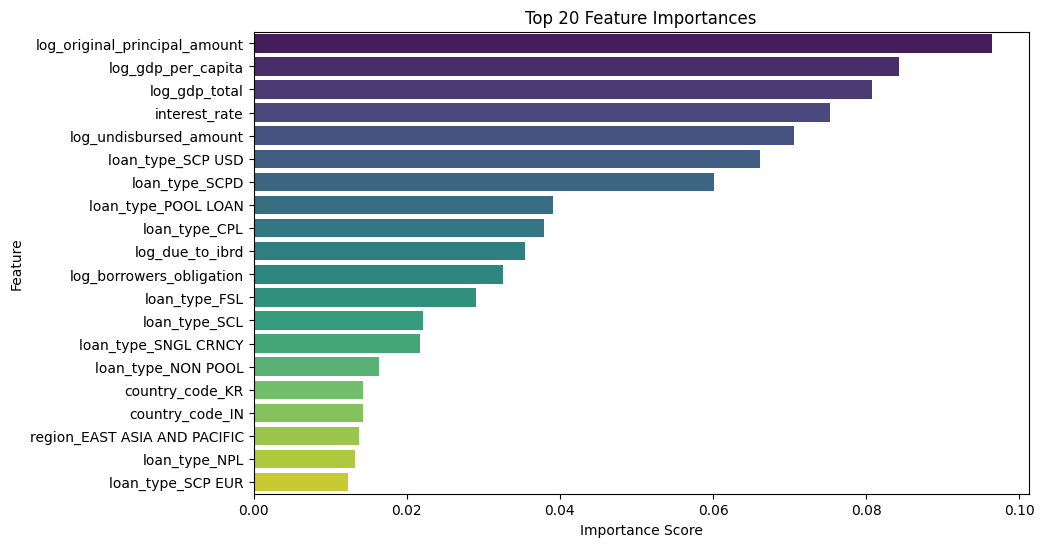

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances.head(20), y=importances.head(20).index, palette="viridis")
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


In [38]:
import pandas as pd

# Get feature importances and sort them descending
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Print top 30 for clarity
print("=== Top 30 Most Important Features ===\n")
for feature, importance in importances.head(30).items():
    print(f"{feature:40s} {importance:.4f}")

# Print bottom 10 (least important)
print("\n=== 10 Least Important Features ===\n")
for feature, importance in importances.tail(10).items():
    print(f"{feature:40s} {importance:.4f}")


=== Top 30 Most Important Features ===

log_original_principal_amount            0.0964
log_gdp_per_capita                       0.0843
log_gdp_total                            0.0808
interest_rate                            0.0752
log_undisbursed_amount                   0.0706
loan_type_SCP USD                        0.0661
loan_type_SCPD                           0.0601
loan_type_POOL LOAN                      0.0391
loan_type_CPL                            0.0380
log_due_to_ibrd                          0.0354
log_borrowers_obligation                 0.0326
loan_type_FSL                            0.0290
loan_type_SCL                            0.0221
loan_type_SNGL CRNCY                     0.0218
loan_type_NON POOL                       0.0163
country_code_KR                          0.0143
country_code_IN                          0.0143
region_EAST ASIA AND PACIFIC             0.0138
loan_type_NPL                            0.0133
loan_type_SCP EUR                        0.0124
